In [19]:
import numpy as np #učitavanje biblioteke sa konceptima linearne algebre
import pandas as pd #učitavanje bibioteke za manipulaciju podataka
import warnings
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

#učitavanje podataka
telcom = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
telcom.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [20]:
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']

for i in replace_cols :
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})

telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

def tenure_lab(telcom) :

    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom),
                                      axis = 1)

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#id kolona
Id_col     = ['customerID']
#kolona ciljne promenljive
target_col = ["Churn"]
#kategoričke kolone
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numeričke kolone
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#binarne kolone sa 2 vrednosti
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#kolone sa više vrednosti
multi_cols = [i for i in cat_cols if i not in bin_cols]

#promena vrednosti kolone sa tekstualnog tipa u numeričke vrednosti
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])

#kreiranje "dummy" kolona za kategoričke kolone sa više od 2 vrednosti
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

#skaliranje vrednosti numeričkih kolona
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#zamena starih numeričkih kolona novim skaliranim
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

summary = (df_telcom_og[[i for i in df_telcom_og.columns if i not in Id_col]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "promenljiva"})
summary = np.around(summary,3)

val_lst = [summary['promenljiva'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Opis promenljivih"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)

In [25]:
#korelacije
correlation = telcom.corr()
matrix_cols = correlation.columns.tolist()
corr_array  = np.array(correlation)

#prikaz matrice korelacija
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X = telcom[[i for i in telcom.columns if i not in Id_col + target_col]]
Y = telcom[target_col + Id_col]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components,columns = ["PC1","PC2"])
pca_data = pca_data.merge(Y,left_index=True,right_index=True,how="left")
pca_data["Churn"] = pca_data["Churn"].replace({1:"Churn",0:"Not Churn"})

def pca_scatter(target,color) :
    tracer = go.Scatter(x = pca_data[pca_data["Churn"] == target]["PC1"] ,
                        y = pca_data[pca_data["Churn"] == target]["PC2"],
                        name = target,mode = "markers",
                        marker = dict(color = color,
                                      line = dict(width = .5),
                                      symbol =  "diamond-open"),
                        text = ("Customer Id : " +
                                pca_data[pca_data["Churn"] == target]['customerID'])
                       )
    return tracer

layout = go.Layout(dict(title = "Visualising data with principal components",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 1",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 2",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 600
                       )
                  )
trace1 = pca_scatter("Churn",'red')
trace2 = pca_scatter("Not Churn",'royalblue')
data = [trace2,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1268
           1       0.69      0.53      0.60       490

   micro avg       0.80      0.80      0.80      1758
   macro avg       0.76      0.72      0.73      1758
weighted avg       0.79      0.80      0.79      1758

Accuracy   Score :  0.8026166097838453
Area under curve :  0.7185443893645785 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



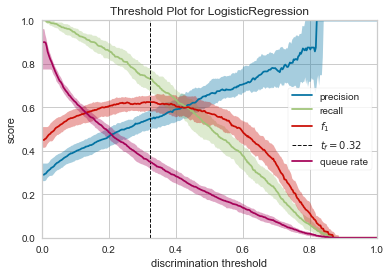

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold
#splitting train and test data
train,test = train_test_split(telcom,test_size = .25 ,random_state = 111)

##seperating dependent and independent variables
cols    = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

#Function attributes
#dataframe     - tabela sa podacima
#Algorithm     - algoritam koji se koristi
#training_x    - trening set
#testing_x     - tests set
#training_y    - prave ciljne vrednosti trening seta
#testing_y    - prave ciljne vrednosti test seta



def telecom_churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :

    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)

    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)

    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions)
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])

    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")

    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))

    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))

    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))

    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)

    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)

    if threshold_plot == True :
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG,display

df_x = df_telcom_og[cols]
df_y = df_telcom_og[target_col]

def plot_decision_tree(columns,maximum_depth,criterion_type,
                       split_type,model_performance = None) :

    #separating dependent and in dependent variables
    dtc_x = df_x[columns]
    dtc_y = df_y[target_col]

    #model
    dt_classifier = DecisionTreeClassifier(max_depth = maximum_depth,
                                           splitter  = split_type,
                                           criterion = criterion_type,
                                          )
    dt_classifier.fit(dtc_x,dtc_y)

    #plot decision tree
    graph = Source(tree.export_graphviz(dt_classifier,out_file=None,
                                        rounded=True,proportion = False,
                                        feature_names = columns,
                                        precision  = 2,
                                        class_names=["Not churn","Churn"],
                                        filled = True
                                       )
                  )

    #model performance
    if model_performance == True :
        telecom_churn_prediction(dt_classifier,
                                 dtc_x,test_X[columns],
                                 dtc_y,test_Y,
                                 columns,"features",threshold_plot = True)
    display(graph)

plot_decision_tree(["tenure","MonthlyCharges","TotalCharges"],3,"gini","best")

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.96      0.86      1268
           1       0.74      0.27      0.39       490

   micro avg       0.77      0.77      0.77      1758
   macro avg       0.76      0.62      0.63      1758
weighted avg       0.76      0.77      0.73      1758

Accuracy   Score :  0.7696245733788396
Area under curve :  0.6155346681259254 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



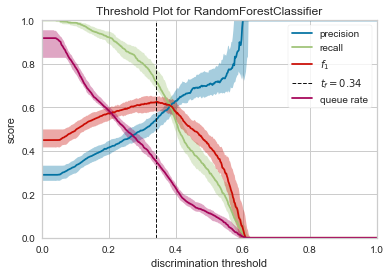

In [18]:
from sklearn.ensemble import RandomForestClassifier

#function attributes
#columns  - column used
#nf_estimators   - The number of trees in the forest.
#estimated_tree  - tree number to be displayed
#maximum_depth   - depth of the tree
#criterion_type  - split criterion type ["gini" or "entropy"]
#Model performance - prints performance of model

def plot_tree_randomforest(columns,nf_estimators,
                           estimated_tree,maximum_depth,
                           criterion_type,model_performance = None) :

    dataframe = df_telcom_og[columns + target_col].copy()

    #train and test datasets
    rf_x = dataframe[[i for i in columns if i not in target_col]]
    rf_y = dataframe[target_col]

    #random forest classifier
    rfc = RandomForestClassifier(n_estimators = nf_estimators,
                                   max_depth = maximum_depth,
                                   criterion = criterion_type,
                                  )
    rfc.fit(rf_x,rf_y)

    estimated_tree = rfc.estimators_[estimated_tree]

    graph = Source(tree.export_graphviz(estimated_tree,out_file=None,
                                        rounded=True,proportion = False,
                            feature_names = columns,
                            precision  = 2,
                            class_names=["Not churn","Churn"],
                            filled = True))
    display(graph)

    #model performance
    if model_performance == True :
        telecom_churn_prediction(rfc,
                                 rf_x,test_X[columns],
                                 rf_y,test_Y,
                                 columns,"features",threshold_plot = True)


cols1 = [ i for i in train_X.columns if i not in target_col + Id_col]
plot_tree_randomforest(cols1,100,99,3,"entropy",True)
